In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import random
from tqdm import tqdm
import networkx as nx
import numpy as np
import pickle
from glob import glob
from pathlib import Path

HOME_DIR = Path.cwd()
while not (HOME_DIR / "src").exists() and HOME_DIR != HOME_DIR.parent:
    HOME_DIR = HOME_DIR.parent

SRC_DIR = HOME_DIR / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from graph_creator.utilities import make_node_edge_df
from subgraphs.SubgraphIsomorphismChecker import IsomorphicGrapCoverageCounter
from graph_creator.ActorGraph import ActorType

from subgraphs.subgraph_types import get_all_subgraphs, get_simple_patterns, get_complex_patterns
from subgraphs.SubgraphExtractor import SubgraphExtractor

PLOTS_DIR = HOME_DIR / "article" / "plots"
COVERAGE_HOLES_DIR = HOME_DIR / "coverage_holes"
DATA_CACHE_DIR = HOME_DIR / "data" / "cache"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
COVERAGE_HOLES_DIR.mkdir(parents=True, exist_ok=True)
DATA_CACHE_DIR.mkdir(parents=True, exist_ok=True)



In [4]:
graph_setting = '1_50_50_10_20_20_4_4_4'
carla_graph_dir = f'carla_actor_graph_setting_{graph_setting}'
argoverse_graph_dir = f'argoverse_actor_graph_setting_{graph_setting}'

ACTOR_GRAPHS_DIR = HOME_DIR / "actor_graphs"
carla_components_dir = ACTOR_GRAPHS_DIR / carla_graph_dir / f"{carla_graph_dir}_components_nx"
argo_components_dir = ACTOR_GRAPHS_DIR / argoverse_graph_dir / f"{argoverse_graph_dir}_components_nx"

assert carla_components_dir.exists(), f"CARLA components directory not found: {carla_components_dir}"
assert argo_components_dir.exists(), f"Argoverse components directory not found: {argo_components_dir}"

graph_paths_carla_components = [str(p) for p in carla_components_dir.glob("*.pkl")]
graph_paths_argo_components = [str(p) for p in argo_components_dir.glob("*.pkl")]

## Subgraph Patterns

In [5]:
coverage_graphs = get_all_subgraphs()


In [7]:
cache_file_carla = DATA_CACHE_DIR / "carla_coverage_data.pkl"

if cache_file_carla.exists():
    cov_data_df_carla = pd.read_pickle(cache_file_carla)
    print(f"Loaded cached CARLA coverage data: {len(cov_data_df_carla)} graphs")
else:
    isom_cov_counter_carla = IsomorphicGrapCoverageCounter(
        coverage_graphs, 
        graph_paths_carla_components[:], 
        node_match=["actor_type", "lane_change", "is_on_intersection"], 
        edge_match=["edge_type"]
    )
    isom_cov_counter_carla.count_isomorphic_graphs()
    cov_data_df_carla = isom_cov_counter_carla.cov_data_df
    cov_data_df_carla.to_pickle(cache_file_carla)
    print(f"Computed and cached CARLA coverage data: {len(cov_data_df_carla)} graphs")

cov_data_df_carla.head(10)

NameError: name 'DATA_CACHE_DIR' is not defined

In [ ]:
cache_file_argo = DATA_CACHE_DIR / "argoverse_coverage_data.pkl"

if cache_file_argo.exists():
    cov_data_df_argo = pd.read_pickle(cache_file_argo)
    print(f"Loaded cached Argoverse coverage data: {len(cov_data_df_argo)} graphs")
else:
    isom_cov_counter_argo = IsomorphicGrapCoverageCounter(
        coverage_graphs, 
        graph_paths_argo_components[:], 
        node_match=["actor_type", "lane_change", "is_on_intersection"], 
        edge_match=["edge_type"]
    )
    isom_cov_counter_argo.count_isomorphic_graphs()
    cov_data_df_argo = isom_cov_counter_argo.cov_data_df
    cov_data_df_argo.to_pickle(cache_file_argo)
    print(f"Computed and cached Argoverse coverage data: {len(cov_data_df_argo)} graphs")

cov_data_df_argo.head(5)

Checking isomorphic graphs: 0it [00:00, ?it/s]

Argoverse coverage analysis complete!
Shape: (0, 22)


,simple_following,simple_opposite,simple_neighbor,lead_vehicle_in_front_with_neighbor_vehicle_intersection,cut_in,cut_in_intersection,platoon_with_intersection,opposite_traffic_at_intersection,lead_with_neighbor_at_intersection,triple_opposite_traffic_intersection,...,cut_out,cut_out_intersection,four_vehicle_intersection_platoon,four_vehicle_opposite_intersection,lead_neighbor_opposite_vehicle,lead_neighbor_opposite_vehicle_intersection,degree,density,diameter,path


## Coverage Metrics


In [ ]:
def calculate_coverage_metrics(cov_df, dataset_name):
    subgraph_cols = [col for col in cov_df.columns if col not in ['degree', 'density', 'diameter', 'path']]
    absolute_coverage = cov_df[subgraph_cols].sum()
    relative_coverage = (cov_df[subgraph_cols].sum() / len(cov_df)) * 100
    
    coverage_df = pd.DataFrame({
        'subgraph': subgraph_cols,
        'absolute_count': absolute_coverage.values,
        'relative_percentage': relative_coverage.values
    })
    return coverage_df.sort_values('absolute_count', ascending=False)

coverage_carla = calculate_coverage_metrics(cov_data_df_carla, "CARLA")
coverage_argo = calculate_coverage_metrics(cov_data_df_argo, "ARGOVERSE")



Coverage Metrics for CARLA
Total graphs analyzed: 0

Top 10 most covered subgraphs:
                                           subgraph  absolute_count  relative_percentage
                                   simple_following             0.0                  NaN
                                    simple_opposite             0.0                  NaN
                     lead_neighbor_opposite_vehicle             0.0                  NaN
                 four_vehicle_opposite_intersection             0.0                  NaN
                  four_vehicle_intersection_platoon             0.0                  NaN
                               cut_out_intersection             0.0                  NaN
                                            cut_out             0.0                  NaN
lead_vehicle_in_front_following_vehicle_in_the_back             0.0                  NaN
        lead_vehicle_in_front_with_neighbor_vehicle             0.0                  NaN
               triple_opp

## Dataset Comparison


In [ ]:
comparison_df = pd.merge(
    coverage_carla[['subgraph', 'absolute_count', 'relative_percentage']],
    coverage_argo[['subgraph', 'absolute_count', 'relative_percentage']],
    on='subgraph',
    suffixes=('_carla', '_argo')
)

comparison_df['abs_diff'] = comparison_df['absolute_count_carla'] - comparison_df['absolute_count_argo']
comparison_df['rel_diff'] = comparison_df['relative_percentage_carla'] - comparison_df['relative_percentage_argo']

threshold_rare = 1.0
comparison_df['hole_in_carla'] = comparison_df['relative_percentage_carla'] < threshold_rare
comparison_df['hole_in_argo'] = comparison_df['relative_percentage_argo'] < threshold_rare

comparison_df



COVERAGE COMPARISON: CARLA vs ARGOVERSE

1. Subgraphs with LARGEST DIFFERENCES (sorted by relative difference):
                                           subgraph  absolute_count_carla  relative_percentage_carla  absolute_count_argo  relative_percentage_argo  abs_diff  rel_diff  hole_in_carla  hole_in_argo
                                   simple_following                   0.0                        NaN                  0.0                       NaN       0.0       NaN          False         False
                                    simple_opposite                   0.0                        NaN                  0.0                       NaN       0.0       NaN          False         False
                     lead_neighbor_opposite_vehicle                   0.0                        NaN                  0.0                       NaN       0.0       NaN          False         False
                 four_vehicle_opposite_intersection                   0.0                        Na

,subgraph,absolute_count_carla,relative_percentage_carla,absolute_count_argo,relative_percentage_argo,abs_diff,rel_diff,hole_in_carla,hole_in_argo
0,simple_following,0.0,NaN,0.0,NaN,0.0,NaN,False,False
1,simple_opposite,0.0,NaN,0.0,NaN,0.0,NaN,False,False
2,lead_neighbor_opposite_vehicle,0.0,NaN,0.0,NaN,0.0,NaN,False,False
3,four_vehicle_opposite_intersection,0.0,NaN,0.0,NaN,0.0,NaN,False,False
4,four_vehicle_intersection_platoon,0.0,NaN,0.0,NaN,0.0,NaN,False,False
5,cut_out_intersection,0.0,NaN,0.0,NaN,0.0,NaN,False,False
6,cut_out,0.0,NaN,0.0,NaN,0.0,NaN,False,False
7,lead_vehicle_in_front_following_vehicle_in_the...,0.0,NaN,0.0,NaN,0.0,NaN,False,False
8,lead_vehicle_in_front_with_neighbor_vehicle,0.0,NaN,0.0,NaN,0.0,NaN,False,False
9,triple_opposite_traffic_intersection,0.0,NaN,0.0,NaN,0.0,NaN,False,False


## Visualizations


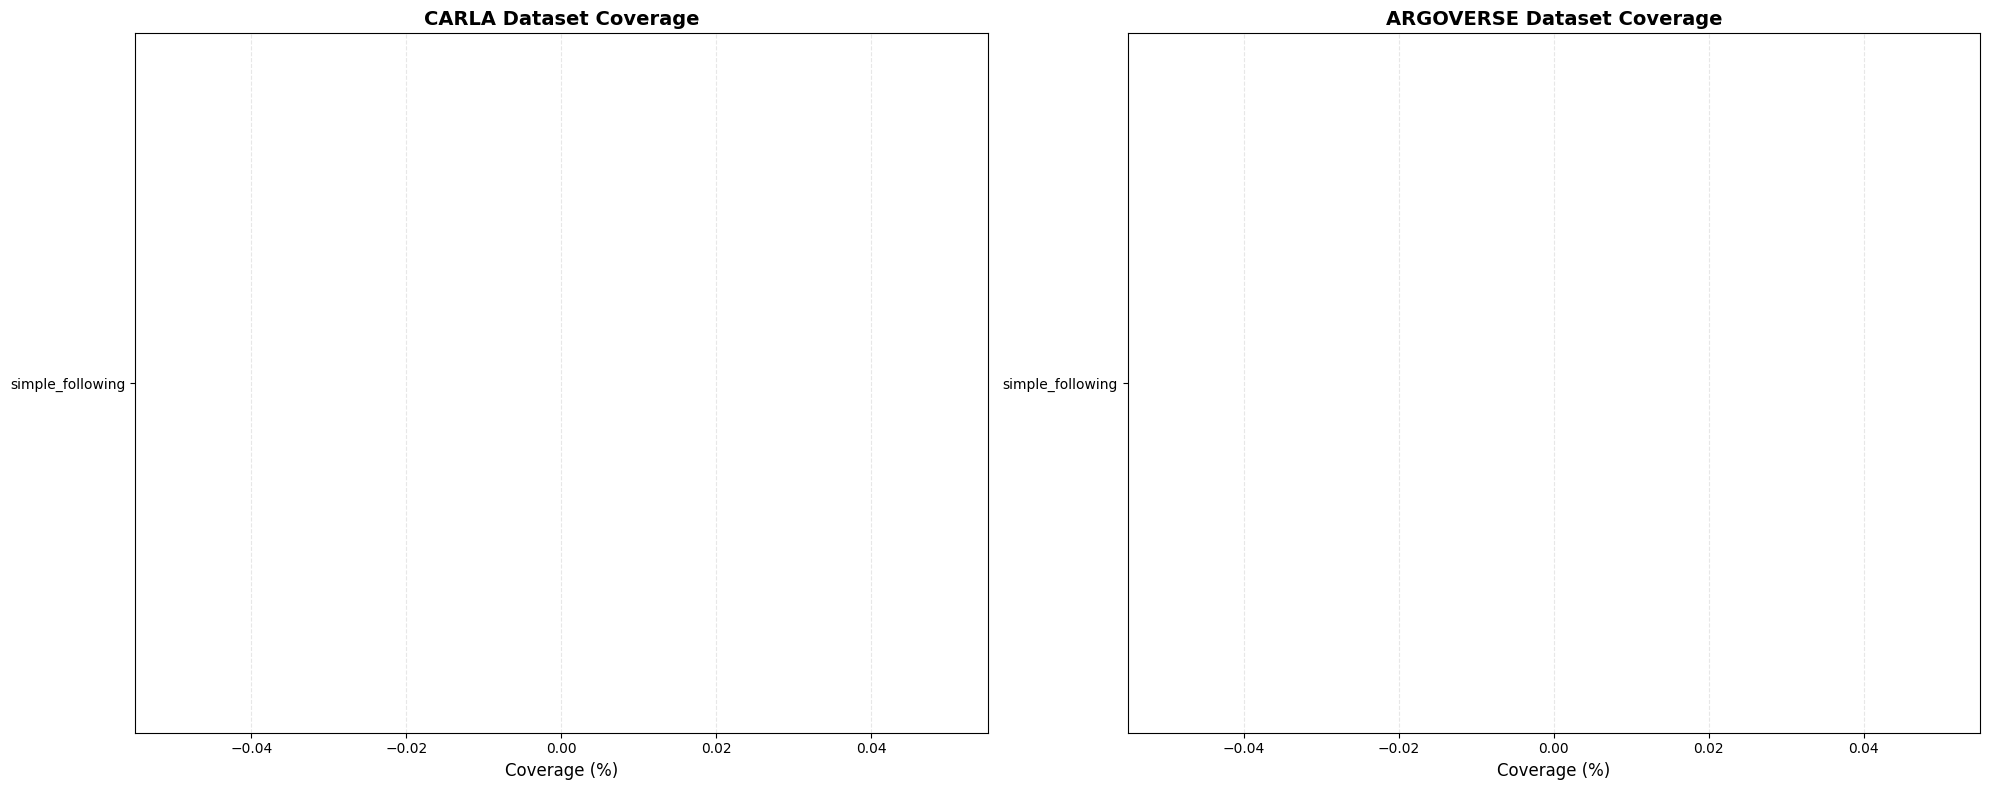

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
comparison_sorted = comparison_df.sort_values('relative_percentage_carla', ascending=True)

axes[0].barh(comparison_sorted['subgraph'], comparison_sorted['relative_percentage_carla'], 
             color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Coverage (%)', fontsize=12)
axes[0].set_title('CARLA Dataset Coverage', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

axes[1].barh(comparison_sorted['subgraph'], comparison_sorted['relative_percentage_argo'], 
             color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Coverage (%)', fontsize=12)
axes[1].set_title('ARGOVERSE Dataset Coverage', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'coverage_comparison_side_by_side.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 10))

comparison_sorted = comparison_df.copy()
comparison_sorted['avg_coverage'] = (comparison_sorted['relative_percentage_carla'] + comparison_sorted['relative_percentage_argo']) / 2
comparison_sorted = comparison_sorted.sort_values('avg_coverage', ascending=True)

x_pos = np.arange(len(comparison_sorted))
width = 0.35

ax1.barh(x_pos - width/2, comparison_sorted['relative_percentage_carla'], 
         width, label='CARLA Coverage', color='skyblue', alpha=0.8)
ax1.barh(x_pos + width/2, comparison_sorted['relative_percentage_argo'], 
         width, label='Argoverse Coverage', color='coral', alpha=0.8)

ax1.set_xlabel('Coverage (%)', fontsize=12)
ax1.set_ylabel('Subgraph Pattern', fontsize=12)
ax1.set_yticks(x_pos)
ax1.set_yticklabels(comparison_sorted['subgraph'], fontsize=9)
ax1.tick_params(axis='y', labelsize=9)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

ax2 = ax1.twiny()
colors = ['green' if x > 0 else 'red' for x in comparison_sorted['rel_diff']]
ax2.scatter(comparison_sorted['rel_diff'], x_pos, 
           c=colors, s=100, alpha=0.6, marker='D', 
           label='Difference (C-A)', edgecolors='black', linewidths=1)

ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax2.set_xlabel('Coverage Difference (CARLA - Argoverse) %', fontsize=12)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(axis='x', alpha=0.3, linestyle=':', color='gray')

plt.title('Dataset Coverage Comparison: Percentages and Differences\n(Green = More in CARLA, Red = More in Argoverse)', 
         fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'coverage_comparison_dual_axis.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

barchart_df_carla = cov_data_df_carla[coverage_graphs.keys()].sum().reset_index().rename(columns={"index":"scenario", 0: "count"})
barchart_df_carla = barchart_df_carla.sort_values('count', ascending=False)
axes[0].bar(range(len(barchart_df_carla)), barchart_df_carla['count'], 
            color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xticks(range(len(barchart_df_carla)))
axes[0].set_xticklabels(barchart_df_carla['scenario'], rotation=45, ha='right')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('CARLA: Subgraph Coverage (Absolute Counts)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

barchart_df_argo = cov_data_df_argo[coverage_graphs.keys()].sum().reset_index().rename(columns={"index":"scenario", 0: "count"})
barchart_df_argo = barchart_df_argo.sort_values('count', ascending=False)
axes[1].bar(range(len(barchart_df_argo)), barchart_df_argo['count'], 
            color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(barchart_df_argo)))
axes[1].set_xticklabels(barchart_df_argo['scenario'], rotation=45, ha='right')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('ARGOVERSE: Subgraph Coverage (Absolute Counts)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'subgraph_coverage_barcharts.png', dpi=300, bbox_inches='tight')
plt.show()

## Speed and Path Analysis


In [ ]:
def extract_scenario_data_with_roles(cov_df, scenario_name, scenario_pattern, node_match_attrs, edge_match_attrs, max_samples=500):
    scenario_graph_paths = cov_df[cov_df[scenario_name]].path.to_list()
    
    if len(scenario_graph_paths) > max_samples:
        scenario_graph_paths = random.sample(scenario_graph_paths, max_samples)
    
    node_dfs = []
    edge_dfs = []
    
    for graph_path in tqdm(scenario_graph_paths, desc=f"Loading {scenario_name}"):
        try:
            with open(graph_path, "rb") as file:
                ag_nx = pickle.load(file)
            
            GM = nx.algorithms.isomorphism.DiGraphMatcher(
                ag_nx, scenario_pattern,
                node_match=nx.algorithms.isomorphism.categorical_node_match(node_match_attrs, [None] * len(node_match_attrs)),
                edge_match=nx.algorithms.isomorphism.categorical_edge_match(edge_match_attrs, [None] * len(edge_match_attrs))
            )
            
            mapping = None
            for m in GM.subgraph_isomorphisms_iter():
                mapping = m
                break
            
            if mapping is None:
                continue
            
            node_to_role = {main_node: pattern_node for main_node, pattern_node in mapping.items()}
            node_df, edge_df = make_node_edge_df(ag_nx)
            
            node_df["role"] = node_df["node_id"].map(node_to_role)
            node_df["role"] = node_df["role"].fillna("other")
            
            node_df["path"] = graph_path
            edge_df["path"] = graph_path
            node_df["scenario"] = scenario_name
            edge_df["scenario"] = scenario_name
            
            node_dfs.append(node_df)
            edge_dfs.append(edge_df)
        except Exception as e:
            continue
    
    if len(node_dfs) == 0:
        return None, None
    
    return pd.concat(node_dfs, ignore_index=True), pd.concat(edge_dfs, ignore_index=True)


In [ ]:
top_scenarios_carla = coverage_carla[coverage_carla['relative_percentage'] >= 5.0]['subgraph'].head(10).tolist()
top_scenarios_argo = coverage_argo[coverage_argo['relative_percentage'] >= 5.0]['subgraph'].head(10).tolist()

node_match_attrs = ["actor_type", "lane_change", "is_on_intersection"]
edge_match_attrs = ["edge_type"]

carla_scenario_nodes = []
carla_scenario_edges = []

for scenario in top_scenarios_carla[:5]:
    scenario_pattern = coverage_graphs[scenario]
    node_df, edge_df = extract_scenario_data_with_roles(
        cov_data_df_carla, scenario, scenario_pattern, 
        node_match_attrs, edge_match_attrs, max_samples=300
    )
    if node_df is not None:
        carla_scenario_nodes.append(node_df)
        carla_scenario_edges.append(edge_df)

if len(carla_scenario_nodes) > 0:
    carla_all_nodes = pd.concat(carla_scenario_nodes, ignore_index=True)
    carla_all_edges = pd.concat(carla_scenario_edges, ignore_index=True)

argo_scenario_nodes = []
argo_scenario_edges = []

for scenario in top_scenarios_argo[:5]:
    scenario_pattern = coverage_graphs[scenario]
    node_df, edge_df = extract_scenario_data_with_roles(
        cov_data_df_argo, scenario, scenario_pattern,
        node_match_attrs, edge_match_attrs, max_samples=300
    )
    if node_df is not None:
        argo_scenario_nodes.append(node_df)
        argo_scenario_edges.append(edge_df)

if len(argo_scenario_nodes) > 0:
    argo_all_nodes = pd.concat(argo_scenario_nodes, ignore_index=True)
    argo_all_edges = pd.concat(argo_scenario_edges, ignore_index=True)


In [ ]:
if len(carla_scenario_nodes) > 0:
    n_scenarios = len(carla_scenario_nodes)
    fig, axes = plt.subplots(n_scenarios, 2, figsize=(14, 4*n_scenarios))
    
    if n_scenarios == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (node_df, edge_df) in enumerate(zip(carla_scenario_nodes, carla_scenario_edges)):
        scenario_name = node_df['scenario'].iloc[0]
        
        # Speed distribution
        axes[idx, 0].hist(node_df['lon_speed'], bins=30, color='skyblue', 
                         edgecolor='black', alpha=0.7)
        axes[idx, 0].set_xlabel('Longitudinal Speed (m/s)', fontsize=10)
        axes[idx, 0].set_ylabel('Frequency', fontsize=10)
        axes[idx, 0].set_title(f'Speed Distribution\n{scenario_name}', 
                               fontsize=11, fontweight='bold')
        axes[idx, 0].grid(axis='y', alpha=0.3, linestyle='--')
        
        # Path length distribution
        axes[idx, 1].hist(edge_df['path_length'], bins=30, color='coral', 
                         edgecolor='black', alpha=0.7)
        axes[idx, 1].set_xlabel('Path Length (m)', fontsize=10)
        axes[idx, 1].set_ylabel('Frequency', fontsize=10)
        axes[idx, 1].set_title(f'Path Length Distribution\n{scenario_name}', 
                               fontsize=11, fontweight='bold')
        axes[idx, 1].grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.suptitle('CARLA: Speed and Path Distributions by Scenario', 
                 fontsize=16, fontweight='bold', y=1.001)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'carla_speed_path_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()


NameError: name 'carla_scenario_nodes' is not defined

TODO: Why are there negative paths length? 

In [ ]:
if len(argo_scenario_nodes) > 0:
    n_scenarios = len(argo_scenario_nodes)
    fig, axes = plt.subplots(n_scenarios, 2, figsize=(14, 4*n_scenarios))
    
    if n_scenarios == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (node_df, edge_df) in enumerate(zip(argo_scenario_nodes, argo_scenario_edges)):
        scenario_name = node_df['scenario'].iloc[0]
        
        # Speed distribution
        axes[idx, 0].hist(node_df['lon_speed'], bins=30, color='skyblue', 
                         edgecolor='black', alpha=0.7)
        axes[idx, 0].set_xlabel('Longitudinal Speed (m/s)', fontsize=10)
        axes[idx, 0].set_ylabel('Frequency', fontsize=10)
        axes[idx, 0].set_title(f'Speed Distribution\n{scenario_name}', 
                               fontsize=11, fontweight='bold')
        axes[idx, 0].grid(axis='y', alpha=0.3, linestyle='--')
        
        # Path length distribution
        axes[idx, 1].hist(edge_df['path_length'], bins=30, color='coral', 
                         edgecolor='black', alpha=0.7)
        axes[idx, 1].set_xlabel('Path Length (m)', fontsize=10)
        axes[idx, 1].set_ylabel('Frequency', fontsize=10)
        axes[idx, 1].set_title(f'Path Length Distribution\n{scenario_name}', 
                               fontsize=11, fontweight='bold')
        axes[idx, 1].grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.suptitle('ARGOVERSE: Speed and Path Distributions by Scenario', 
                 fontsize=16, fontweight='bold', y=1.001)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'argo_speed_path_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()


NameError: name 'argo_scenario_nodes' is not defined

In [ ]:
if len(carla_scenario_nodes) > 0 and len(argo_scenario_nodes) > 0:
    common_scenarios = set([df['scenario'].iloc[0] for df in carla_scenario_nodes]) & \
                      set([df['scenario'].iloc[0] for df in argo_scenario_nodes])


SPEED DISTRIBUTION COMPARISON: Identifying Coverage Holes


NameError: name 'carla_scenario_nodes' is not defined

In [ ]:
# Comparative analysis of path length distributions
if len(carla_scenario_edges) > 0 and len(argo_scenario_edges) > 0:
    common_scenarios = set([df['scenario'].iloc[0] for df in carla_scenario_edges]) & \
                      set([df['scenario'].iloc[0] for df in argo_scenario_edges])


PATH LENGTH DISTRIBUTION COMPARISON: Identifying Coverage Holes


NameError: name 'carla_scenario_edges' is not defined

In [ ]:
if len(carla_scenario_nodes) > 0 and len(argo_scenario_nodes) > 0:
    common_scenarios = list(set([df['scenario'].iloc[0] for df in carla_scenario_nodes]) & 
                           set([df['scenario'].iloc[0] for df in argo_scenario_nodes]))
    
    if len(common_scenarios) > 0:
        n_scenarios = min(len(common_scenarios), 2)
        
        for scenario in common_scenarios[:n_scenarios]:
            carla_node_data = [df for df in carla_scenario_nodes if df['scenario'].iloc[0] == scenario][0]
            argo_node_data = [df for df in argo_scenario_nodes if df['scenario'].iloc[0] == scenario][0]
            
            all_roles = sorted([r for r in carla_node_data['role'].unique() if r != 'other'])
            
            if len(all_roles) == 0:
                continue
            
            n_roles = len(all_roles)
            fig, axes = plt.subplots(n_roles, 2, figsize=(16, 4*n_roles))
            
            if n_roles == 1:
                axes = axes.reshape(1, -1)
            
            for role_idx, role in enumerate(all_roles):
                carla_role_data = carla_node_data[carla_node_data['role'] == role]
                argo_role_data = argo_node_data[argo_node_data['role'] == role]
                carla_speed = carla_role_data[carla_role_data['lon_speed'] >= 2.0]['lon_speed']
                argo_speed = argo_role_data[argo_role_data['lon_speed'] >= 2.0]['lon_speed']
                
                if len(carla_speed) == 0 or len(argo_speed) == 0:
                    axes[role_idx, 0].text(0.5, 0.5, f'Insufficient data for role "{role}"', 
                                          ha='center', va='center', fontsize=12)
                    axes[role_idx, 0].set_xlim(0, 1)
                    axes[role_idx, 0].set_ylim(0, 1)
                    axes[role_idx, 0].axis('off')
                else:
                    combined_max = max(carla_speed.max(), argo_speed.max())
                    bin_edges_speed = np.arange(2.0, combined_max + 1.0, 1.0)
                    combined_min = 2.0
                    
                    argo_hist, _ = np.histogram(argo_speed, bins=bin_edges_speed, density=True)
                    carla_hist, _ = np.histogram(carla_speed, bins=bin_edges_speed, density=True)
                    axes[role_idx, 0].hist(carla_speed, bins=bin_edges_speed, alpha=0.6, 
                                          label=f'CARLA (n={len(carla_speed)})', color='skyblue', density=True)
                    axes[role_idx, 0].hist(argo_speed, bins=bin_edges_speed, alpha=0.6, 
                                          label=f'Argoverse (n={len(argo_speed)})', color='coral', density=True)
                    
                    axes[role_idx, 0].set_xlim(combined_min, combined_max)
                    ylim = axes[role_idx, 0].get_ylim()
                    y_middle = ylim[1] * 0.5
                    rect_height = ylim[1] * 0.08
                    
                    high_threshold = 0.01
                    hole_added = False
                    for i in range(len(bin_edges_speed) - 1):
                        if argo_hist[i] >= high_threshold and carla_hist[i] < (argo_hist[i] * 0.1):
                            x_start = bin_edges_speed[i]
                            bin_width = bin_edges_speed[i+1] - bin_edges_speed[i]
                            
                            if not hole_added:
                                axes[role_idx, 0].add_patch(plt.Rectangle((x_start, y_middle - rect_height/2),
                                                                         bin_width, rect_height,
                                                                         facecolor='green', edgecolor='darkgreen',
                                                                         alpha=0.7, linewidth=2,
                                                                         label='CARLA Hole', zorder=10))
                                hole_added = True
                            else:
                                axes[role_idx, 0].add_patch(plt.Rectangle((x_start, y_middle - rect_height/2),
                                                                         bin_width, rect_height,
                                                                         facecolor='green', edgecolor='darkgreen',
                                                                         alpha=0.7, linewidth=2, zorder=10))
                    
                    axes[role_idx, 0].set_xlabel('Longitudinal Speed (m/s)', fontsize=10)
                    axes[role_idx, 0].set_ylabel('Density', fontsize=10)
                    axes[role_idx, 0].set_title(f'Speed Comparison - Role "{role}" (v >= 2 m/s)', 
                                               fontsize=11, fontweight='bold')
                    axes[role_idx, 0].legend(loc='best', fontsize=9)
                    axes[role_idx, 0].grid(axis='y', alpha=0.3, linestyle='--')
                
                carla_role_node_ids = carla_role_data['node_id'].tolist()
                argo_role_node_ids = argo_role_data['node_id'].tolist()
                
                carla_edge_data = [df for df in carla_scenario_edges if df['scenario'].iloc[0] == scenario][0]
                argo_edge_data = [df for df in argo_scenario_edges if df['scenario'].iloc[0] == scenario][0]
                carla_role_edges = carla_edge_data[carla_edge_data['source'].isin(carla_role_node_ids)]
                argo_role_edges = argo_edge_data[argo_edge_data['source'].isin(argo_role_node_ids)]
                
                if len(carla_role_edges) == 0 or len(argo_role_edges) == 0:
                    axes[role_idx, 1].text(0.5, 0.5, f'Insufficient edge data for role "{role}"', 
                                          ha='center', va='center', fontsize=12)
                    axes[role_idx, 1].set_xlim(0, 1)
                    axes[role_idx, 1].set_ylim(0, 1)
                    axes[role_idx, 1].axis('off')
                else:
                    combined_min_path = 0.0
                    combined_max_path = max(carla_role_edges['path_length'].max(), argo_role_edges['path_length'].max())
                    bin_edges_path = np.arange(0.0, combined_max_path + 5.0, 5.0)
                    
                    argo_hist_path, _ = np.histogram(argo_role_edges['path_length'], bins=bin_edges_path, density=True)
                    carla_hist_path, _ = np.histogram(carla_role_edges['path_length'], bins=bin_edges_path, density=True)
                    axes[role_idx, 1].hist(carla_role_edges['path_length'], bins=bin_edges_path, alpha=0.6, 
                                          label=f'CARLA (n={len(carla_role_edges)})', color='skyblue', density=True)
                    axes[role_idx, 1].hist(argo_role_edges['path_length'], bins=bin_edges_path, alpha=0.6, 
                                          label=f'Argoverse (n={len(argo_role_edges)})', color='coral', density=True)
                    
                    axes[role_idx, 1].set_xlim(combined_min_path, combined_max_path)
                    ylim_path = axes[role_idx, 1].get_ylim()
                    y_middle_path = ylim_path[1] * 0.5
                    rect_height_path = ylim_path[1] * 0.08
                    
                    high_threshold_path = 0.01
                    hole_added_path = False
                    for i in range(len(bin_edges_path) - 1):
                        if argo_hist_path[i] >= high_threshold_path and carla_hist_path[i] < (argo_hist_path[i] * 0.1):
                            x_start_path = bin_edges_path[i]
                            bin_width_path = bin_edges_path[i+1] - bin_edges_path[i]
                            
                            if not hole_added_path:
                                axes[role_idx, 1].add_patch(plt.Rectangle((x_start_path, y_middle_path - rect_height_path/2),
                                                                         bin_width_path, rect_height_path,
                                                                         facecolor='green', edgecolor='darkgreen',
                                                                         alpha=0.7, linewidth=2,
                                                                         label='CARLA Hole', zorder=10))
                                hole_added_path = True
                            else:
                                axes[role_idx, 1].add_patch(plt.Rectangle((x_start_path, y_middle_path - rect_height_path/2),
                                                                         bin_width_path, rect_height_path,
                                                                         facecolor='green', edgecolor='darkgreen',
                                                                         alpha=0.7, linewidth=2, zorder=10))
                    
                    axes[role_idx, 1].set_xlabel('Path Length (m)', fontsize=10)
                    axes[role_idx, 1].set_ylabel('Density', fontsize=10)
                    axes[role_idx, 1].set_title(f'Path Length Comparison - Role "{role}"', 
                                               fontsize=11, fontweight='bold')
                    axes[role_idx, 1].legend(loc='best', fontsize=9)
                    axes[role_idx, 1].grid(axis='y', alpha=0.3, linestyle='--')
            
            plt.suptitle(f'Role-Specific Distribution Comparison: {scenario}\n(Green rectangles = CARLA coverage holes)', 
                         fontsize=14, fontweight='bold', y=0.995)
            plt.tight_layout()
            plt.savefig(PLOTS_DIR / f'role_comparison_{scenario.replace("/", "_")}.png', dpi=300, bbox_inches='tight')
            plt.show()


NameError: name 'carla_scenario_nodes' is not defined

In [ ]:
speed_holes_data = []
path_holes_data = []

if len(carla_scenario_nodes) > 0 and len(argo_scenario_nodes) > 0:
    common_scenarios = list(set([df['scenario'].iloc[0] for df in carla_scenario_nodes]) & 
                           set([df['scenario'].iloc[0] for df in argo_scenario_nodes]))
    
    for scenario in common_scenarios:
        carla_node_data = [df for df in carla_scenario_nodes if df['scenario'].iloc[0] == scenario][0]
        argo_node_data = [df for df in argo_scenario_nodes if df['scenario'].iloc[0] == scenario][0]
        
        all_roles = sorted([r for r in carla_node_data['role'].unique() if r != 'other'])
        
        for role in all_roles:
            carla_role_data = carla_node_data[carla_node_data['role'] == role]
            argo_role_data = argo_node_data[argo_node_data['role'] == role]
            
            carla_speed = carla_role_data[carla_role_data['lon_speed'] >= 2.0]['lon_speed']
            argo_speed = argo_role_data[argo_role_data['lon_speed'] >= 2.0]['lon_speed']
            
            if len(carla_speed) > 0 and len(argo_speed) > 0:
                combined_max = max(carla_speed.max(), argo_speed.max())
                bin_edges_speed = np.arange(2.0, combined_max + 1.0, 1.0)
                
                argo_hist, _ = np.histogram(argo_speed, bins=bin_edges_speed, density=True)
                carla_hist, _ = np.histogram(carla_speed, bins=bin_edges_speed, density=True)
                
                high_threshold = 0.01
                for i in range(len(bin_edges_speed) - 1):
                    if argo_hist[i] >= high_threshold and carla_hist[i] < (argo_hist[i] * 0.1):
                        speed_min = bin_edges_speed[i]
                        speed_max = bin_edges_speed[i+1]
                        argo_in_range = argo_role_data[
                            (argo_role_data['lon_speed'] >= speed_min) & 
                            (argo_role_data['lon_speed'] < speed_max)
                        ]
                        
                        for _, row in argo_in_range.iterrows():
                            speed_holes_data.append({
                                'scenario': scenario,
                                'role': role,
                                'speed_range_min': speed_min,
                                'speed_range_max': speed_max,
                                'argoverse_graph_path': row['path'],
                                'argoverse_node_id': row['node_id'],
                                'actual_speed': row['lon_speed'],
                                'argo_density': argo_hist[i],
                                'carla_density': carla_hist[i],
                                'density_gap': argo_hist[i] - carla_hist[i]
                            })
            
            carla_role_node_ids = carla_role_data['node_id'].tolist()
            argo_role_node_ids = argo_role_data['node_id'].tolist()
            
            carla_edge_data = [df for df in carla_scenario_edges if df['scenario'].iloc[0] == scenario][0]
            argo_edge_data = [df for df in argo_scenario_edges if df['scenario'].iloc[0] == scenario][0]
            
            carla_role_edges = carla_edge_data[carla_edge_data['source'].isin(carla_role_node_ids)]
            argo_role_edges = argo_edge_data[argo_edge_data['source'].isin(argo_role_node_ids)]
            
            if len(carla_role_edges) > 0 and len(argo_role_edges) > 0:
                combined_max_path = max(carla_role_edges['path_length'].max(), argo_role_edges['path_length'].max())
                bin_edges_path = np.arange(0.0, combined_max_path + 5.0, 5.0)
                
                argo_hist_path, _ = np.histogram(argo_role_edges['path_length'], bins=bin_edges_path, density=True)
                carla_hist_path, _ = np.histogram(carla_role_edges['path_length'], bins=bin_edges_path, density=True)
                
                high_threshold_path = 0.01
                for i in range(len(bin_edges_path) - 1):
                    if argo_hist_path[i] >= high_threshold_path and carla_hist_path[i] < (argo_hist_path[i] * 0.1):
                        path_min = bin_edges_path[i]
                        path_max = bin_edges_path[i+1]
                        argo_in_range = argo_role_edges[
                            (argo_role_edges['path_length'] >= path_min) & 
                            (argo_role_edges['path_length'] < path_max)
                        ]
                        
                        for _, row in argo_in_range.iterrows():
                            path_holes_data.append({
                                'scenario': scenario,
                                'role': role,
                                'path_range_min': path_min,
                                'path_range_max': path_max,
                                'argoverse_graph_path': row['path'],
                                'edge_source': row['source'],
                                'edge_target': row['target'],
                                'actual_path_length': row['path_length'],
                                'argo_density': argo_hist_path[i],
                                'carla_density': carla_hist_path[i],
                                'density_gap': argo_hist_path[i] - carla_hist_path[i]
                            })

speed_holes_df = pd.DataFrame(speed_holes_data)
if len(speed_holes_df) > 0:
    speed_holes_df.to_csv(COVERAGE_HOLES_DIR / 'carla_speed_distribution_holes.csv', index=False)

path_holes_df = pd.DataFrame(path_holes_data)
if len(path_holes_df) > 0:
    path_holes_df.to_csv(COVERAGE_HOLES_DIR / 'carla_path_distribution_holes.csv', index=False)



2. Exporting speed and path distribution holes...



NameError: name 'carla_scenario_nodes' is not defined

/var/folders/69/gf952_9954987cw6v2224l9h0000gn/T/ipykernel_55248/3398408896.py:10: RuntimeWarning: invalid value encountered in scalar divide
  cooccurrence_matrix[i, j] = cov_data_df_carla[col1].sum() / len(cov_data_df_carla) * 100
/var/folders/69/gf952_9954987cw6v2224l9h0000gn/T/ipykernel_55248/3398408896.py:13: RuntimeWarning: invalid value encountered in scalar divide
  cooccurrence = (cov_data_df_carla[col1] & cov_data_df_carla[col2]).sum() / len(cov_data_df_carla) * 100


FileNotFoundError: [Errno 2] No such file or directory: 'plots/carla_agreement_matrix.png'

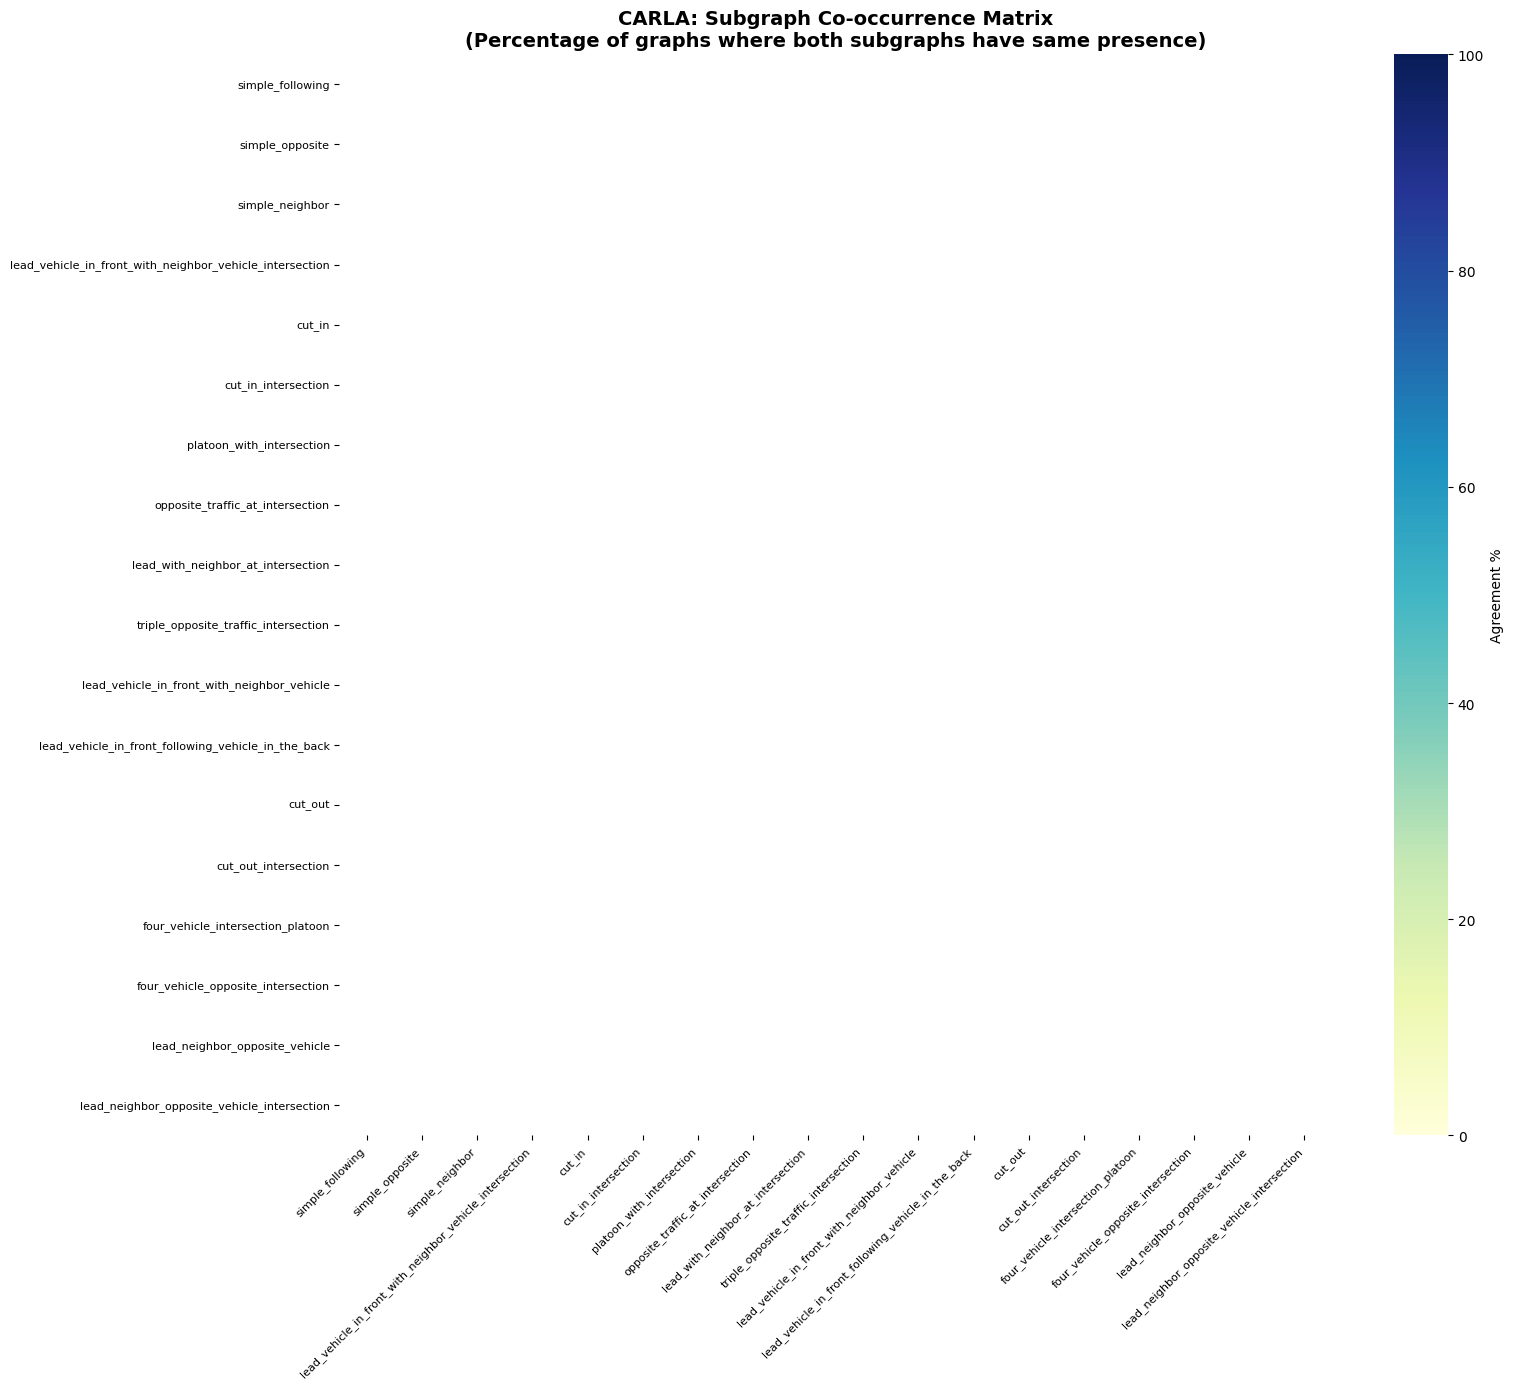

In [ ]:
columns = list(coverage_graphs.keys())
n_cols = len(columns)
cooccurrence_matrix = np.zeros((n_cols, n_cols))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if i == j:
            cooccurrence_matrix[i, j] = cov_data_df_carla[col1].sum() / len(cov_data_df_carla) * 100
        else:
            cooccurrence = (cov_data_df_carla[col1] & cov_data_df_carla[col2]).sum() / len(cov_data_df_carla) * 100
            cooccurrence_matrix[i, j] = cooccurrence

cooccurrence_df_carla = pd.DataFrame(cooccurrence_matrix, index=columns, columns=columns)
agreement_df_carla = cooccurrence_df_carla
plt.figure(figsize=(16, 14))
sns.heatmap(agreement_df_carla, 
            annot=False,
            cmap='YlGnBu',
            vmin=0, 
            vmax=100,
            cbar_kws={'label': 'Agreement %'},
            xticklabels=True,
            yticklabels=True)
plt.title('CARLA: Subgraph Co-occurrence Matrix\n(Percentage of graphs where both subgraphs have same presence)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'carla_agreement_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
columns = list(coverage_graphs.keys())
n_cols = len(columns)
cooccurrence_matrix = np.zeros((n_cols, n_cols))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if i == j:
            cooccurrence_matrix[i, j] = cov_data_df_argo[col1].sum() / len(cov_data_df_argo) * 100
        else:
            cooccurrence = (cov_data_df_argo[col1] & cov_data_df_argo[col2]).sum() / len(cov_data_df_argo) * 100
            cooccurrence_matrix[i, j] = cooccurrence

cooccurrence_df_argo = pd.DataFrame(cooccurrence_matrix, index=columns, columns=columns)
agreement_df_argo = cooccurrence_df_argo
plt.figure(figsize=(16, 14))
sns.heatmap(agreement_df_argo, 
            annot=False,
            cmap='YlGnBu',
            vmin=0, 
            vmax=100,
            cbar_kws={'label': 'Agreement %'},
            xticklabels=True,
            yticklabels=True)
plt.title('ARGOVERSE: Subgraph Co-occurrence Matrix\n(Percentage of graphs where both subgraphs have same presence)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'argo_agreement_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Co-occurrence Holes



In [ ]:
def name_cooccurrence_hole(pattern1: str, pattern2: str) -> str:
    name_map = {
        'simple_2actor_overtaking': 'Overtaking',
        'simple_2actor_following': 'Following',
        'simple_2actor_merging': 'Merging',
        'simple_2actor_crossing': 'Crossing',
        'simple_2actor_oncoming': 'Oncoming',
        'complex_3actor_chain': '3-Chain',
        'complex_3actor_merge': '3-Merge',
        'complex_3actor_split': '3-Split',
        'complex_4actor_intersection': '4-Intersection',
        'complex_multilane_weave': 'Weave'
    }
    
    short1 = name_map.get(pattern1, pattern1.replace('simple_2actor_', '').replace('complex_', '').title())
    short2 = name_map.get(pattern2, pattern2.replace('simple_2actor_', '').replace('complex_', '').title())
    
    return f"{short1} + {short2}"

argo_high_threshold = 10.0
carla_low_threshold = 2.0

carla_cooccurrence_holes = []

for i in range(len(agreement_df_carla)):
    for j in range(i+1, len(agreement_df_carla)):
        argo_val = agreement_df_argo.iloc[i, j]
        carla_val = agreement_df_carla.iloc[i, j]
        
        if argo_val >= argo_high_threshold and carla_val < carla_low_threshold:
            pattern1 = agreement_df_carla.index[i]
            pattern2 = agreement_df_carla.columns[j]
            carla_cooccurrence_holes.append({
                'name': name_cooccurrence_hole(pattern1, pattern2),
                'pattern1': pattern1,
                'pattern2': pattern2,
                'argoverse_cooccurrence': argo_val,
                'carla_cooccurrence': carla_val,
                'difference': argo_val - carla_val
            })

carla_cooccurrence_holes_df = pd.DataFrame(carla_cooccurrence_holes).sort_values('difference', ascending=False) if len(carla_cooccurrence_holes) > 0 else pd.DataFrame(carla_cooccurrence_holes)

argo_cooccurrence_holes = []

for i in range(len(agreement_df_carla)):
    for j in range(i+1, len(agreement_df_carla)):
        carla_val = agreement_df_carla.iloc[i, j]
        argo_val = agreement_df_argo.iloc[i, j]
        
        if carla_val >= argo_high_threshold and argo_val < carla_low_threshold:
            pattern1 = agreement_df_carla.index[i]
            pattern2 = agreement_df_carla.columns[j]
            argo_cooccurrence_holes.append({
                'name': name_cooccurrence_hole(pattern1, pattern2),
                'pattern1': pattern1,
                'pattern2': pattern2,
                'carla_cooccurrence': carla_val,
                'argoverse_cooccurrence': argo_val,
                'difference': carla_val - argo_val
            })

argo_cooccurrence_holes_df = pd.DataFrame(argo_cooccurrence_holes).sort_values('difference', ascending=False) if len(argo_cooccurrence_holes) > 0 else pd.DataFrame(argo_cooccurrence_holes)

subgraph_holes_data = []

for _, hole_row in comparison_df[comparison_df['hole_in_carla']].iterrows():
    scenario_name = hole_row['subgraph']
    argo_graphs_with_scenario = cov_data_df_argo[cov_data_df_argo[scenario_name] == True]['path'].tolist()
    
    for graph_path in argo_graphs_with_scenario:
        subgraph_holes_data.append({
            'scenario': scenario_name,
            'argoverse_graph_path': graph_path,
            'argo_absolute_count': hole_row['absolute_count_argo'],
            'argo_relative_percentage': hole_row['relative_percentage_argo'],
            'carla_absolute_count': hole_row['absolute_count_carla'],
            'carla_relative_percentage': hole_row['relative_percentage_carla'],
            'coverage_gap': hole_row['abs_diff']
        })

subgraph_holes_df = pd.DataFrame(subgraph_holes_data)
if len(subgraph_holes_df) > 0:
    subgraph_holes_df.to_csv(COVERAGE_HOLES_DIR / 'carla_subgraph_holes.csv', index=False)

cooccurrence_holes_data = []

for _, hole_row in carla_cooccurrence_holes_df.iterrows():
    pattern1 = hole_row['pattern1']
    pattern2 = hole_row['pattern2']
    
    argo_graphs_with_both = cov_data_df_argo[
        (cov_data_df_argo[pattern1] == True) & 
        (cov_data_df_argo[pattern2] == True)
    ]['path'].tolist()
    
    for graph_path in argo_graphs_with_both:
        cooccurrence_holes_data.append({
            'combination_name': hole_row['name'],
            'pattern1': pattern1,
            'pattern2': pattern2,
            'argoverse_graph_path': graph_path,
            'argo_cooccurrence_rate': hole_row['argoverse_cooccurrence'],
            'carla_cooccurrence_rate': hole_row['carla_cooccurrence'],
            'cooccurrence_gap': hole_row['difference']
        })

cooccurrence_holes_df_export = pd.DataFrame(cooccurrence_holes_data)
if len(cooccurrence_holes_df_export) > 0:
    cooccurrence_holes_df_export.to_csv(COVERAGE_HOLES_DIR / 'carla_cooccurrence_holes.csv', index=False)


NameError: name 'agreement_df_argo' is not defined

In [ ]:

cooccurrence_diff = agreement_df_carla - agreement_df_argo

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(cooccurrence_diff, 
            cmap='RdBu_r', 
            center=0, 
            vmin=-50, 
            vmax=50,
            cbar_kws={'label': 'Co-occurrence Difference (CARLA - Argoverse) %'},
            xticklabels=True,
            yticklabels=True,
            ax=ax)

ax.set_title('Co-occurrence Difference Matrix: CARLA vs ARGOVERSE\n' + 
             '(Red = More co-occurrence in CARLA, Blue = More in Argoverse)', 
             fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'cooccurrence_difference_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


NameError: name 'agreement_df_argo' is not defined